# Heat-IBVP-1

This notebook implements the BCGP and PCGP experiments for Heat-IBVP-1 from Section 5.3.1 of the manuscript

## Preliminaries 

Whether to run computations on GPU or CPU

In [1]:
import os

USE_GPU: bool = True

if not USE_GPU:
    os.environ['JAX_PLATFORM_NAME'] = 'cpu'
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

Package imports

In [2]:
import jax.numpy as jnp
from jax import config, random, devices

import os
import pickle
from numpy import savetxt

# ensure that we can access jax_pigp
import sys
sys.path.append('../../')

import jax_pigp
from jax_pigp.utility_fns import softplus, generate_params, PARAM_OPTIONS_DICT as param_gen_options
from jax_pigp.base import Callable, Array

from utility_fns import *

# double precision prevents nans
config.update("jax_enable_x64", True) 
config.update("jax_debug_nans", False) 

Check what devices are available

In [3]:
devices()

[CudaDevice(id=0)]

### Specify settings of the experiments

In [4]:
# base random seed for parameter initialisation
BASE_SEED_VAL: int = 444

# true value of the heat parameter theta 
THETA_TRUE: Array  = jnp.array([1.])

# bounds from which to randomly sample initial value of theta
THETA_MIN: Array = jnp.array([5.])
THETA_MAX: Array = jnp.array([10.])
THETA_BOUNDS = [THETA_MIN, THETA_MAX]

# Set to True to consider inverse problem of identifying theta
RUN_INVERSE: bool = True

# specify how GP handles boundary conditions 
GP_TYPE = 'bcgp'
assert GP_TYPE in ['bcgp', 'pcgp', 'ucgp'] 

# number of u/f space observations to use for inference
N_DATA: int = 25
Nu: int = N_DATA
Nf: int = N_DATA
# number of boundary points to use for PCGP
Nb: int = 50 if GP_TYPE=="pcgp" else 0

# path to subdirectory in /data where Heat-IBVP-1 data is saved
data_save_dir: str = f'heatIBVP1'
data_save_dir_full = os.path.join('data', data_save_dir)
assert os.path.isdir(data_save_dir_full)

# dimensionality of the spatio-temporal domain (including time)
INPUT_DIM: int = 2

# initial value for std of noise levels for u / f / boundary points
NOISE_INIT = jnp.array([0.1]*3)

# softplus transformation ensures noise and theta values are positive
THETA_TRANSFORM: Callable = softplus
NOISE_TRANSFORM: Callable = softplus

# whether to save all test set prediction results or just summary statistics
SAVE_ALL_PREDICTIONS: bool = True

# options for model training
N_TRAIN_STEPS: int = 5000
N_RESTARTS: int    = 3
LR_INIT: float     = 0.025
VERBOSE: bool      = False

### Specify boundary-constrained mean and kernel functions

The BCGP mean $(\tilde{m})$ and kernel $(\tilde{k})$ functions are presented in Appendix B.2.3 of the manuscript, and they are designed to ensure that the BCGP exactly satisfies the Dirichlet initial condition at $t=0$ and Dirichlet boundary conditions for $x \in \partial \Omega =  \{\pi/2, -\pi/2\}$. These functions take the form

 \begin{align*} 
 \tilde{m}(x,t) = & \;\frac{2 x}{\pi}  \exp(-t) + (1-t) \left(\sin(x) - \frac{2 x}{\pi}\right),  \\
 \tilde{k}([x,t], [x',t']) = &\; \phi(x,t)\phi(x',t')k([x,t], [x',t']),
 \end{align*}

Note that there is a slight typo in the formula for $\tilde{m}$ in the manuscript.

where the ADF $\phi$ is given by

\begin{equation*}
\phi(x,t)  = \left(x + \frac{\pi}{2}\right)\left(\frac{\pi}{2} - x\right)t.
\end{equation*}

The above equations are implemented as follows: 

In [5]:
base_kernel = jax_pigp.kernels.squared_exponential

if GP_TYPE == "bcgp":
    print(f'using boundary constrained mean and kernel')
    
    def phi(loc: Array):
        x, t = loc 
        return (jnp.pi/2. - x)*(x + jnp.pi/2.)*t
    
    def kernel_fn(params: dict, loc1: Array, loc2: Array):

        k_params = params['kernel_params_1']
    
        base_kernel_val = base_kernel(k_params, loc1, loc2)
    
        cov_val = phi(loc1)*phi(loc2)*base_kernel_val
    
        return cov_val.squeeze()
    
    def mean_fn(params: dict, loc: Array):
        x, t = loc 
        two_x_pi = 2*x/jnp.pi
        return jnp.exp(-t)*two_x_pi + (1.-t)*(jnp.sin(x) - two_x_pi)    

else:
    print(f'using unconstrained mean and kernel')
    
    def kernel_fn(params: dict, loc1: Array, loc2: Array):

        k_params = params['kernel_params_1']
    
        return base_kernel(k_params, loc1, loc2)
    
    mean_fn= lambda p, loc: loc[0]*0.

using boundary constrained mean and kernel


### Specify heat differential operator

Recall that the heat PDE over one spatial dimension takes the form

$$\mathcal{L}^{\theta}_{x,t}[u] =   \frac{\partial u}{\partial t} - \theta \frac{\partial^2 u}{\partial x^2} = f = 0,$$
where $\theta$ is the thermal diffusivity coefficient. 

##### Implementation: 

* We define a dummy linear operator for $u$-space data which is just the identity transformation
* $f$ is returned by calling the ``apply_PDE`` function defined below


In [6]:
def apply_Identity(fn: Callable,argnum: int = 1):
    return fn

def apply_PDE(fn: Callable, argnum: int = 1):
    r"""
    Applies the heat PDE to input fn at specified argnum
    """

    # the Jacobian and Hessian functions    
    Jfn, Hfn = jac_hess(fn, argnum)

    def PDE(params: dict, loc1: Array, *loc2: Array):
        ## Note: we assume spatial value comes before temporal value in loc1 and loc2
        
        theta = THETA_TRANSFORM(params['theta'])[0] if RUN_INVERSE else THETA_TRUE[0]

        # time derivative is the second element of the Jacobian vector
        _, ut_val = Jfn(params, loc1, *loc2)

        # second spatial derivative is upper left element of the Hessian matrix
        uxx_val = Hfn(params, loc1, *loc2)[0,0]
        
        return ut_val - theta*uxx_val
        
    return PDE 

# the first operator corresponds to the observations yu, the second
# to pde observations yf, and the final to boundary observations of u
linear_operators = [apply_Identity, apply_PDE, apply_Identity]

### Store settings

Store optimisation options in a dictionary

In [7]:
opt_options = {}
opt_options['n_steps']         = N_TRAIN_STEPS 
opt_options['n_restarts']      = N_RESTARTS
opt_options['lr']              = LR_INIT
opt_options['verbose']         = VERBOSE
opt_options['theta_transform'] = THETA_TRANSFORM
opt_options['noise_transform'] = NOISE_TRANSFORM

Specify parameter initialisation function

In [8]:
param_gen_options['input_dim']       = [INPUT_DIM]
param_gen_options['noise_std_init']  = NOISE_INIT
param_gen_options['noise_transform'] = NOISE_TRANSFORM
param_gen_options['theta_bounds']    = THETA_BOUNDS
param_gen_options['theta_transform'] = THETA_TRANSFORM

# randomly samples kernel parameter values given an input seed
generate_params_fn = lambda seed: generate_params(seed, param_gen_options)

Create a directory to save the results 

In [9]:
results_save_dir = os.path.join('results', data_save_dir, f'{GP_TYPE}_Nu_{Nu}_Nf_{Nf}_Nb_{Nb}')
if not os.path.isdir(results_save_dir): os.makedirs(results_save_dir)

## Data and model initialisation

### Load train and test data

In [10]:
train_data, test_data = load_data(data_save_dir_full, Nu, Nf, Nb)

Check shapes of train and test data

In [11]:
train_data.ytrain.shape, test_data.us.shape, [X.shape for X in train_data.Xtrain]

((50, 1), (14400, 1), [(25, 2), (25, 2), (0, 2)])

### Initialise PIGP model

In [12]:
heat_kernel_fns = jax_pigp.interdomain_moments.InterdomainKernelFns(kernel_fn, linear_operators)
heat_mean_fns   = jax_pigp.interdomain_moments.InterdomainMeanFns(mean_fn,     linear_operators)

gp_model = jax_pigp.models.GPR(heat_kernel_fns, heat_mean_fns)

### Initialise learner for model training

In [13]:
obj_fn_train = lambda params: -gp_model.log_marginal_likelihood(params, train_data)    

gp_learner = jax_pigp.optimisers.AdamLearner(obj_fn_train, opt_options, generate_params_fn, random.PRNGKey(BASE_SEED_VAL))

Initial parameter values  

In [14]:
print_param_values(gp_learner.params, opt_options)

kernel_params_1
amp: [16.09345497]
ls: [3.46766105 1.08252109]
alpha: [18.48419482]

noise_std: [0.1 0.1 0.1]
theta: [7.55514163]


Objective function value for initial parameters

In [15]:
gp_model.log_marginal_likelihood(gp_learner.params, train_data)

Array(-230.24003155, dtype=float64)

Gradient of the objective function with respect to the initial parameters

In [16]:
gp_learner.grad_obj_fn(gp_learner.params)

(Array(230.24003155, dtype=float64),
 {'kernel_params_1': {'alpha': Array([0.], dtype=float64),
   'amp': Array([-6.75074157], dtype=float64),
   'ls': Array([111.23567508, 252.36478168], dtype=float64)},
  'noise_std': Array([   4.32170891, -207.93885808,    0.        ], dtype=float64),
  'theta': Array([46.80893111], dtype=float64)})

## Training 

[JIT compile](https://jax.readthedocs.io/en/latest/jit-compilation.html) the ``update_one_step`` method by evaluating it once, then train model for specified number of steps/restarts.

In [17]:
gp_learner.lr_schedule(3499), 0.99**500, 1./25.

(Array(0.025, dtype=float64, weak_type=True), 0.006570483042414603, 0.04)

In [18]:
_ = gp_learner.update_one_step(gp_learner.params, gp_learner.opt_state)

In [19]:
print(f'gp_type={GP_TYPE}, Nu/Nf/Nb={Nu}/{Nf}/{Nb}, n_steps={opt_options['n_steps']}, n_restarts={opt_options['n_restarts']}\n')
gp_learner.train_with_restarts(opt_options['n_steps'], 
                               opt_options['n_restarts'], 
                               print_progress = opt_options['verbose'])

gp_type=bcgp, Nu/Nf/Nb=25/25/0, n_steps=5000, n_restarts=3

Restart 0: beginning training for 5000 steps
Final training results: 
(4999): -173.3025, noise_std_vals = [1.01e-02,4.62e-04,1.00e-01], theta = [1.00012437]


Restart 1: beginning training for 5000 steps
Final training results: 
(4999): -177.0503, noise_std_vals = [1.01e-02,1.76e-04,1.00e-01], theta = [0.999002]


Restart 2: beginning training for 5000 steps
Final training results: 
(4999): -177.0228, noise_std_vals = [1.01e-02,1.92e-04,1.00e-01], theta = [0.99900068]




Uncomment below to continue training from existing parameter values:

In [20]:
# gp_learner.train(opt_options["n_steps"])
# gp_learner.params_best = gp_learner.params.copy()

### Plot training results

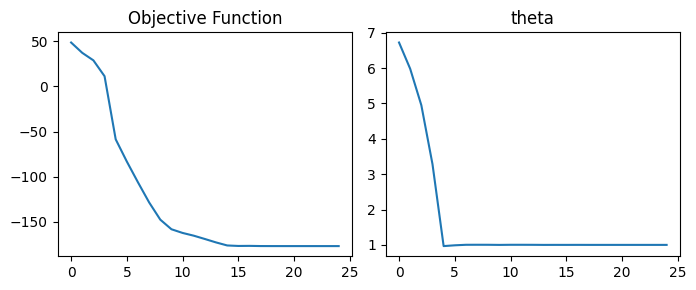

In [21]:
theta_arr = jnp.array(gp_learner.theta_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=TWO_COLUMN_FIGSIZE)

begin_at = int(len(gp_learner.obj_list)*0.05)

plot_lc(axes[0], gp_learner.obj_list[begin_at:], 'Objective Function')
plot_lc(axes[1], theta_arr[begin_at:,0], 'theta')

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, 'learningCurves.pdf'))

### Final trained parameter values

In [22]:
# extract final trained parameter values
trained_params = gp_learner.params_best.copy()

# print the values of the trained parameters
print_param_values(trained_params, opt_options)

# save trained parameters
with open(os.path.join(results_save_dir, 'trained_params.pkl'), 'wb') as fp:
    pickle.dump(trained_params, fp)

kernel_params_1
alpha: [5.93779773]
amp: [0.01221803]
ls: [3.51383298 1.92574775]

noise_std: [0.0101449  0.00017626 0.1       ]
theta: [0.999002]


Can load pre-trained parameters by uncommenting the below

In [23]:
# with open(os.path.join(results_save_dir, 'trained_params.pkl'), 'rb') as f:
    # trained_params = pickle.load(f)

## Test set results

Evaluate posterior distribution at test points, using hyper-parameter values ``trained_params`` obtained during training phase.

In [24]:
# posterior mean and covariance over test points
print(f'Posterior results for {GP_TYPE}, Nu/Nf/Nb={Nu}/{Nf}/{Nb}, Ns={test_data.Xs.shape[0]}')
mu, Sigma = gp_model.posterior_predict(trained_params, train_data, test_data.Xs)
s = jnp.diag(Sigma)**.5

# save predictions
if SAVE_ALL_PREDICTIONS:
    jnp.save(os.path.join(results_save_dir, 'u_pred.npy'), mu)
    jnp.save(os.path.join(results_save_dir, 's_pred.npy'), s)

# test set prediction error
abs_losses = jnp.abs(mu - test_data.us)
print(f'mean/max loss: {abs_losses.mean():3e}/{abs_losses.max():.3e}')
savetxt(os.path.join(results_save_dir, 'mean_loss.txt'), abs_losses.mean().reshape(-1,1))

if RUN_INVERSE:
    theta_pred = opt_options['theta_transform'](trained_params['theta'])
    theta_loss = jnp.linalg.norm(theta_pred - THETA_TRUE)
    print(f'theta_true : {THETA_TRUE}')
    print(f'theta_pred : {theta_pred}')
    print(f'theta_loss : {theta_loss:.3e}')
    savetxt(os.path.join(results_save_dir, 'theta_loss.txt'), jnp.array([theta_loss]))

Posterior results for bcgp, Nu/Nf/Nb=25/25/0, Ns=14400
mean/max loss: 6.260923e-04/1.732e-03
theta_true : [1.]
theta_pred : [0.999002]
theta_loss : 9.980e-04


### Plots of posterior prediction

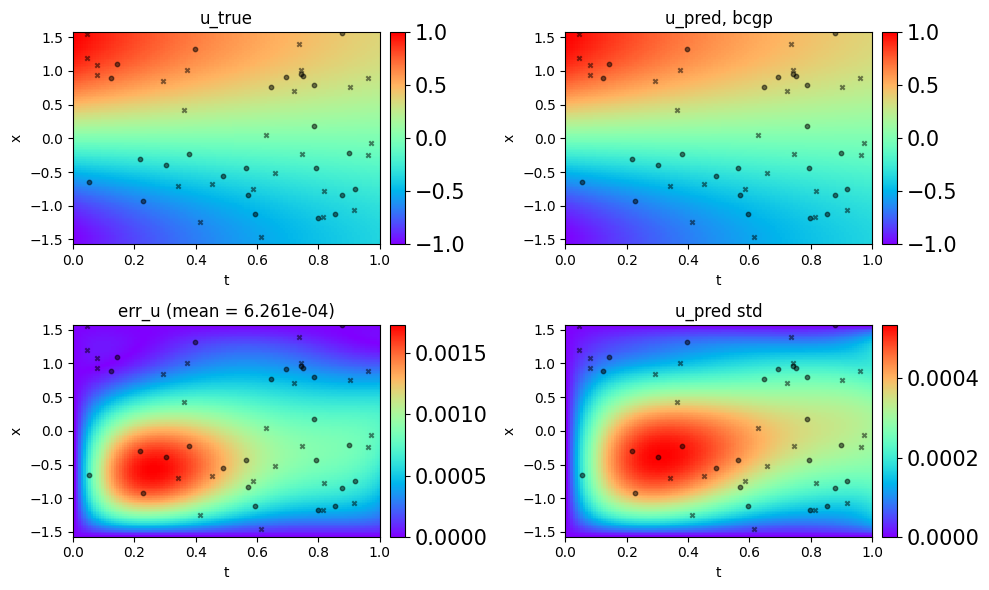

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=TWO_BY_TWO_FIGSIZE)

Nx = len(jnp.unique(test_data.Xs[:,0]))
Nt = len(jnp.unique(test_data.Xs[:,1]))

Xu, Xf, _ = train_data.Xtrain

make_heatmap_heat = lambda ax, output, title=None: make_heatmap(fig, ax, output.reshape(Nt,Nx).T, test_data, Xu, Xf, title)

make_heatmap_heat(axes[0,0], test_data.us, title='u_true')
make_heatmap_heat(axes[0,1], mu, title=f'u_pred, {GP_TYPE}')
make_heatmap_heat(axes[1,0], abs_losses, title=f'err_u (mean = {abs_losses.mean():.3e})')
make_heatmap_heat(axes[1,1], s, title=f'u_pred std')

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, 'posteriorPrediction.pdf'))